In [1]:
#Copyright 2019, Seokjun Bu, Softcomputing LAB all rights reserved.
%matplotlib inline
import glob
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Model, load_model
from keras.utils import np_utils, multi_gpu_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Lambda, concatenate, TimeDistributed, CuDNNLSTM, BatchNormalization, LSTM
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize

Using TensorFlow backend.


In [2]:
# Handcrafted Function Definition
def plot_history(model_input, mode='loss', title='Entropy'):
    history = model_input.history
    plt.plot(history.history[mode])
    plt.plot(history.history['val_'+mode])
    plt.title(title)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
def minmax_normalize_columnwise(input_np):
    output_np = np.zeros((input_np.shape[0], input_np.shape[1]))
    for c in range(input_np.shape[1]):
        col_min, col_max = np.min(input_np[:, c]), np.max(input_np[:, c])
        output_np[:, c] = input_np[:, c]
        output_np[:, c] -= col_min
        output_np[:, c] /= (col_max-col_min)
    return output_np
def sliding_window_np(input_np, window_size, stride):
    n_window = input_np.shape[0]-window_size+1
    X_output, Y_output = np.zeros((input_np.shape[0], window_size, input_np.shape[1])), np.zeros((input_np.shape[0], ))
    for r in range(n_window-1):
        X_output[r] = input_np[r:r+window_size]
        Y_output[r] = input_np[r+window_size, -1]
    return X_output, Y_output

In [3]:
# Column Info.
df = pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df.pkl')
columns = df.columns.values[1:]
print(columns)
drop_cols = ['NO2', 'O3', 'CO', 'SO2', 'PM10', 'PM25']
df = df.drop(drop_cols, axis=1)
columns = df.columns.values[1:]
print(columns)
df.head()

['timestamp' 'hour' 'weekday' 'Temp' 'Precipitation' 'Snowfall'
 'Wind_speed' 'Wind_dir' 'Humidity' 'Air_pressure' 'NO2' 'O3' 'CO' 'SO2'
 'PM10' 'PM25' 'bike_feed' 'bike_count']
['timestamp' 'hour' 'weekday' 'Temp' 'Precipitation' 'Snowfall'
 'Wind_speed' 'Wind_dir' 'Humidity' 'Air_pressure' 'bike_feed'
 'bike_count']


,date,timestamp,hour,weekday,Temp,Precipitation,Snowfall,Wind_speed,Wind_dir,Humidity,Air_pressure,bike_feed,bike_count
0,2017-01-01 00:00:00,1.483196e+09,0,0,0.2,0.0,0.0,2.2,20.0,79.0,1018.8,3020,79
1,2017-01-01 01:00:00,1.483200e+09,1,0,0.0,0.0,0.0,1.4,20.0,78.0,1018.9,3020,83
2,2017-01-01 02:00:00,1.483204e+09,2,0,-0.3,0.0,0.0,1.9,50.0,81.0,1018.5,3020,61
3,2017-01-01 03:00:00,1.483207e+09,3,0,-0.7,0.0,0.0,2.0,50.0,84.0,1018.8,3020,37
4,2017-01-01 04:00:00,1.483211e+09,4,0,-1.1,0.0,0.0,1.6,20.0,85.0,1018.6,3020,24


In [4]:
# Load Dataset
train, validation, test = pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_train_timeseries.pkl').drop(drop_cols, axis=1).values[:, 1:], pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_val_timeseries.pkl').drop(drop_cols, axis=1).values[:, 1:], pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_test_timeseries.pkl').drop(drop_cols, axis=1).values[:, 1:]
print(train.shape, validation.shape, test.shape)

(10461, 13) (4184, 13) (6277, 13)


[[ 0.000e+00  0.000e+00  2.000e-01 ...  0.000e+00  0.000e+00  7.900e+01]
 [ 1.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  8.300e+01]
 [ 2.000e+00  0.000e+00 -3.000e-01 ...  0.000e+00  0.000e+00  6.100e+01]
 ...
 [ 2.200e+01  1.000e+00  1.870e+01 ...  0.000e+00  0.000e+00  3.384e+03]
 [ 2.300e+01  1.000e+00  1.850e+01 ...  0.000e+00  0.000e+00  2.500e+03]
 [ 0.000e+00  1.000e+00  1.750e+01 ...  0.000e+00  0.000e+00  2.264e+03]]


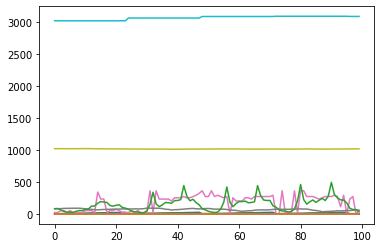

[[0.         0.         0.31468531 ... 0.         0.         0.00772354]
 [0.04347826 0.         0.31118881 ... 0.         0.         0.00811962]
 [0.08695652 0.         0.30594406 ... 0.         0.         0.00594118]
 ...
 [0.95652174 1.         0.63811189 ... 0.         0.         0.33498366]
 [1.         1.         0.63461538 ... 0.         0.         0.24745024]
 [0.         1.         0.61713287 ... 0.         0.         0.22408159]]


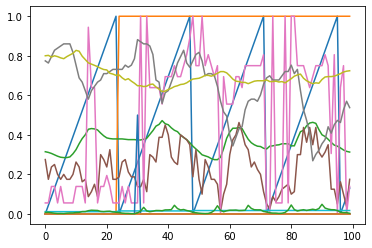

In [5]:
# Normalize Dataset
dataset = np.concatenate((train, validation, test), axis=0)
dataset_norm = minmax_normalize_columnwise(dataset)
lim = 100
print(dataset)
plt.plot(dataset[:lim])
plt.show()
print(dataset_norm)
plt.plot(dataset_norm[:lim])
plt.show()

In [6]:
# Preprocessing: Sliding-window
window_size = 10
n_window = dataset.shape[0]-window_size+1
X, Y = np.zeros((dataset.shape[0], window_size, dataset.shape[1])), np.zeros((dataset.shape[0],))
for r in range(n_window-1):
    X[r], Y[r] = dataset_norm[r:r+window_size], dataset_norm[r+window_size, -1]
print(X.shape, Y.shape)

(20922, 10, 13) (20922,)


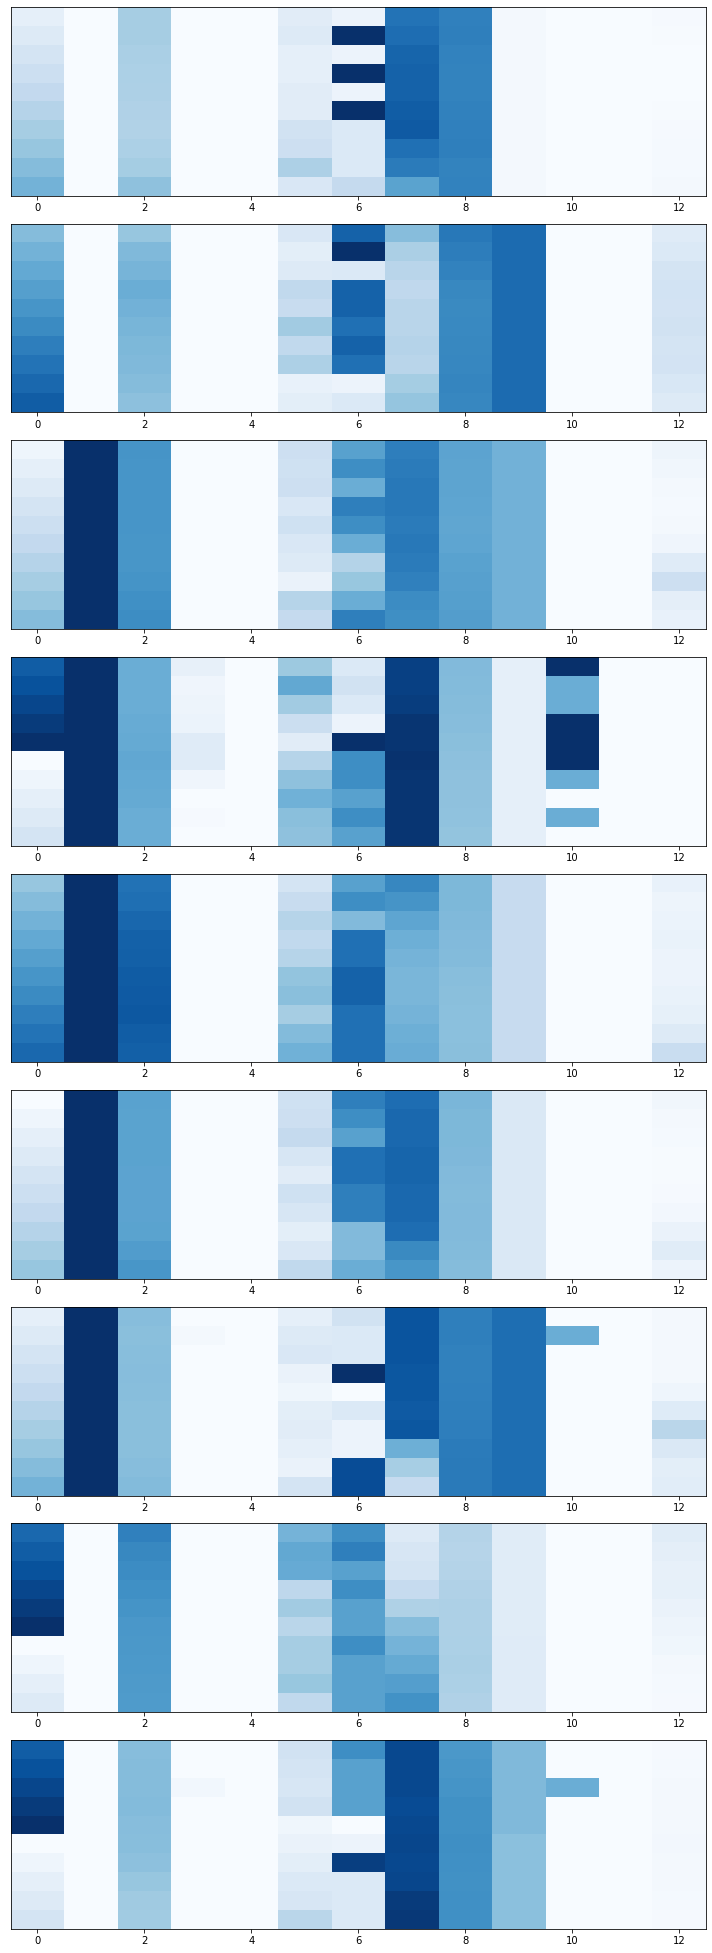

In [7]:
# Visualize Windows, Target Var.
n_vis = 10
rand_idx = np.random.randint(0, X.shape[0], n_vis)
X_sample, Y_sample = X[rand_idx], Y[rand_idx]
fig = plt.figure(figsize=(10, 30))
for nv in range(1, n_vis):
    subplot = fig.add_subplot(n_vis, 1, nv)
    subplot.imshow(X_sample[nv], cmap=plt.cm.Blues, aspect='auto')
    subplot.set_yticks([])
plt.tight_layout()
plt.show()

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(14645, 10, 13) (14645,)
(6277, 10, 13) (6277,)


In [10]:
# Build Model
c_input = Input(shape=(X.shape[1],X.shape[2]))
H = Reshape((X.shape[1], X.shape[2], 1))(c_input)
H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
H = TimeDistributed(MaxPooling1D(2))(H)
H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
H = TimeDistributed(MaxPooling1D(2))(H)
H = TimeDistributed(Flatten())(H)
H = Dropout(0.5)(H)
# H = CuDNNLSTM(128, return_sequences=True)(H)
H = CuDNNLSTM(64, return_sequences=False)(H)
H = Dropout(0.5)(H)
H = Dense(64, activation='tanh')(H)
H = Dense(64, activation='tanh')(H)
c_output = Dense(1, activation='tanh')(H)
model_cnn_lstm = Model(c_input, c_output)
model_cnn_lstm.summary()
model_cnn_lstm = multi_gpu_model(model_cnn_lstm, gpus=4)
model_cnn_lstm.compile(loss='mse', optimizer='adam', metrics=['binary_crossentropy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10, 13)            0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 10, 13, 1)         0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 13, 32)        96        
_________________________________________________________________
time_distributed_7 (TimeDist (None, 10, 6, 32)         0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 10, 6, 32)         2080      
_________________________________________________________________
time_distributed_9 (TimeDist (None, 10, 3, 32)         0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 10, 96)            0         
__________

In [11]:
# Train Model
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
train_history = model_cnn_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=2000, callbacks=[es], verbose=2, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 14645 samples, validate on 6277 samples
Epoch 1/200
 - 11s - loss: 0.0128 - binary_crossentropy: 0.4134 - val_loss: 0.0174 - val_binary_crossentropy: 0.4073
Epoch 2/200
 - 0s - loss: 0.0053 - binary_crossentropy: 0.2608 - val_loss: 0.0158 - val_binary_crossentropy: 0.4002
Epoch 3/200
 - 0s - loss: 0.0044 - binary_crossentropy: 0.2562 - val_loss: 0.0143 - val_binary_crossentropy: 0.3942
Epoch 4/200
 - 0s - loss: 0.0039 - binary_crossentropy: 0.2571 - val_loss: 0.0129 - val_binary_crossentropy: 0.3891
Epoch 5/200
 - 0s - loss: 0.0037 - binary_crossentropy: 0.2550 - val_loss: 0.0114 - val_binary_crossentropy: 0.3842
Epoch 6/200
 - 0s - loss: 0.0034 - binary_crossentropy: 0.2551 - val_loss: 0.0106 - val_binary_crossentropy: 0.3815
Epoch 7/200
 - 0s - loss: 0.0032 - binary_crossentropy: 0.2524 - val_loss: 0.0098 - val_binary_crossentropy: 0.3786
Epoch 8/200
 - 0s - loss: 0.0029 - binary_crossentropy: 0.2517 - val_loss: 0.0091 - val_bi

Epoch 69/200
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2357 - val_loss: 0.0038 - val_binary_crossentropy: 0.3607
Epoch 70/200
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2369 - val_loss: 0.0036 - val_binary_crossentropy: 0.3603
Epoch 71/200
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2360 - val_loss: 0.0034 - val_binary_crossentropy: 0.3596
Epoch 72/200
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2358 - val_loss: 0.0038 - val_binary_crossentropy: 0.3603
Epoch 73/200
 - 0s - loss: 0.0011 - binary_crossentropy: 0.2358 - val_loss: 0.0035 - val_binary_crossentropy: 0.3595
Epoch 74/200
 - 0s - loss: 0.0011 - binary_crossentropy: 0.2358 - val_loss: 0.0038 - val_binary_crossentropy: 0.3602
Epoch 75/200
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2364 - val_loss: 0.0035 - val_binary_crossentropy: 0.3598
Epoch 76/200
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2363 - val_loss: 0.0037 - val_binary_crossentropy: 0.3600
Epoch 77/200
 - 0s - loss: 0.0011 - binary_crossentropy: 0.2350 

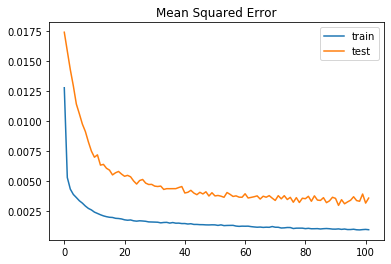

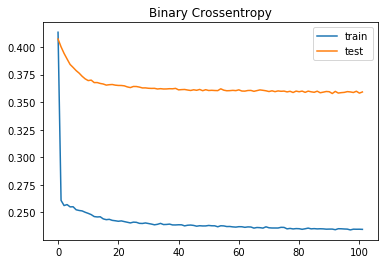

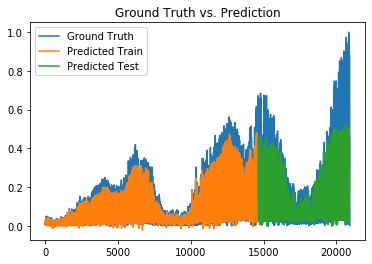

In [12]:
# Validation
# Curve
plot_history(model_cnn_lstm, mode='loss', title='Mean Squared Error')
plot_history(model_cnn_lstm, mode='binary_crossentropy', title='Binary Crossentropy')
# Prediction
Y_train_hat = model_cnn_lstm.predict(X_train)
Y_test_hat = model_cnn_lstm.predict(X_test)
plt.plot(range(Y_train_hat.shape[0]+Y_test_hat.shape[0]), np.concatenate((Y_train, Y_test)), label='Ground Truth') # Ground Truth
plt.plot(range(Y_train_hat.shape[0]), Y_train_hat, label='Predicted Train') # Train Period Prediction
plt.plot(range(Y_train_hat.shape[0], Y_train_hat.shape[0]+Y_test_hat.shape[0]), Y_test_hat, label='Predicted Test') # Test Period Prediction
plt.legend(loc='upper left')
plt.title('Ground Truth vs. Prediction')
plt.show()

In [13]:
# Build Deeper Model
c_input = Input(shape=(X.shape[1],X.shape[2]))
H = Reshape((X.shape[1], X.shape[2], 1))(c_input)
H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
H = TimeDistributed(MaxPooling1D(2))(H)
H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
H = TimeDistributed(MaxPooling1D(2))(H)
H = TimeDistributed(Flatten())(H)
H = Dropout(0.75)(H)
H = CuDNNLSTM(64, return_sequences=True)(H)
H = CuDNNLSTM(64, return_sequences=False)(H)
H = Dropout(0.75)(H)
H = Dense(64, activation='tanh')(H)
H = Dense(64, activation='tanh')(H)
c_output = Dense(1, activation='tanh')(H)
model_cnn_lstm = Model(c_input, c_output)
model_cnn_lstm.summary()
model_cnn_lstm = multi_gpu_model(model_cnn_lstm, gpus=4)
model_cnn_lstm.compile(loss='mse', optimizer='adam', metrics=['binary_crossentropy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10, 13)            0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 10, 13, 1)         0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 13, 32)        96        
_________________________________________________________________
time_distributed_12 (TimeDis (None, 10, 6, 32)         0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 10, 6, 32)         2080      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 10, 3, 32)         0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 10, 96)            0         
__________

In [14]:
# Train Model
es = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
train_history = model_cnn_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=2000, batch_size=2000, callbacks=[es], verbose=2, shuffle=True)

Train on 14645 samples, validate on 6277 samples
Epoch 1/2000
 - 2s - loss: 0.0186 - binary_crossentropy: 0.4752 - val_loss: 0.0266 - val_binary_crossentropy: 0.4680
Epoch 2/2000
 - 0s - loss: 0.0078 - binary_crossentropy: 0.3064 - val_loss: 0.0195 - val_binary_crossentropy: 0.4173
Epoch 3/2000
 - 0s - loss: 0.0065 - binary_crossentropy: 0.2674 - val_loss: 0.0210 - val_binary_crossentropy: 0.4257
Epoch 4/2000
 - 0s - loss: 0.0056 - binary_crossentropy: 0.2569 - val_loss: 0.0180 - val_binary_crossentropy: 0.4099
Epoch 5/2000
 - 0s - loss: 0.0052 - binary_crossentropy: 0.2599 - val_loss: 0.0165 - val_binary_crossentropy: 0.4030
Epoch 6/2000
 - 0s - loss: 0.0049 - binary_crossentropy: 0.2597 - val_loss: 0.0161 - val_binary_crossentropy: 0.4016
Epoch 7/2000
 - 0s - loss: 0.0047 - binary_crossentropy: 0.2591 - val_loss: 0.0159 - val_binary_crossentropy: 0.4008
Epoch 8/2000
 - 0s - loss: 0.0045 - binary_crossentropy: 0.2562 - val_loss: 0.0153 - val_binary_crossentropy: 0.3986
Epoch 9/2000
 -

 - 0s - loss: 0.0019 - binary_crossentropy: 0.2400 - val_loss: 0.0047 - val_binary_crossentropy: 0.3638
Epoch 71/2000
 - 0s - loss: 0.0019 - binary_crossentropy: 0.2396 - val_loss: 0.0051 - val_binary_crossentropy: 0.3649
Epoch 72/2000
 - 0s - loss: 0.0019 - binary_crossentropy: 0.2401 - val_loss: 0.0053 - val_binary_crossentropy: 0.3654
Epoch 73/2000
 - 0s - loss: 0.0019 - binary_crossentropy: 0.2395 - val_loss: 0.0044 - val_binary_crossentropy: 0.3630
Epoch 74/2000
 - 0s - loss: 0.0019 - binary_crossentropy: 0.2396 - val_loss: 0.0047 - val_binary_crossentropy: 0.3638
Epoch 75/2000
 - 0s - loss: 0.0018 - binary_crossentropy: 0.2398 - val_loss: 0.0046 - val_binary_crossentropy: 0.3633
Epoch 76/2000
 - 0s - loss: 0.0018 - binary_crossentropy: 0.2398 - val_loss: 0.0047 - val_binary_crossentropy: 0.3637
Epoch 77/2000
 - 0s - loss: 0.0018 - binary_crossentropy: 0.2392 - val_loss: 0.0052 - val_binary_crossentropy: 0.3650
Epoch 78/2000
 - 0s - loss: 0.0018 - binary_crossentropy: 0.2399 - val

Epoch 140/2000
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2363 - val_loss: 0.0046 - val_binary_crossentropy: 0.3616
Epoch 141/2000
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2362 - val_loss: 0.0042 - val_binary_crossentropy: 0.3602
Epoch 142/2000
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2355 - val_loss: 0.0041 - val_binary_crossentropy: 0.3602
Epoch 143/2000
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2358 - val_loss: 0.0045 - val_binary_crossentropy: 0.3608
Epoch 144/2000
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2361 - val_loss: 0.0046 - val_binary_crossentropy: 0.3614
Epoch 145/2000
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2361 - val_loss: 0.0040 - val_binary_crossentropy: 0.3599
Epoch 146/2000
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2357 - val_loss: 0.0043 - val_binary_crossentropy: 0.3605
Epoch 147/2000
 - 0s - loss: 0.0012 - binary_crossentropy: 0.2356 - val_loss: 0.0043 - val_binary_crossentropy: 0.3604
Epoch 148/2000
 - 0s - loss: 0.0012 - binary_cro

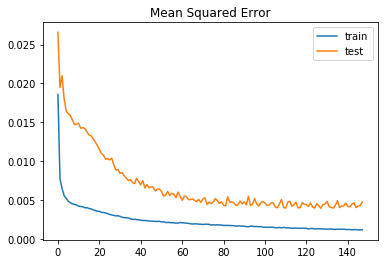

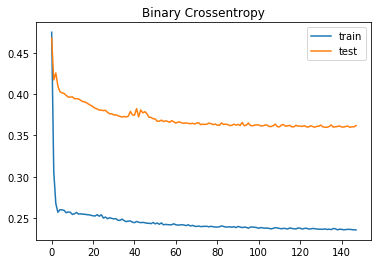

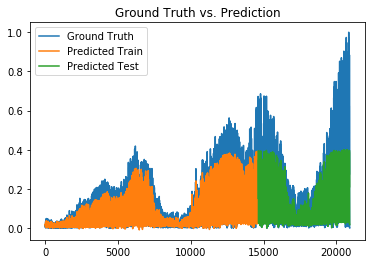

In [15]:
# Validation
# Curve
plot_history(model_cnn_lstm, mode='loss', title='Mean Squared Error')
plot_history(model_cnn_lstm, mode='binary_crossentropy', title='Binary Crossentropy')
# Prediction
Y_train_hat = model_cnn_lstm.predict(X_train)
Y_test_hat = model_cnn_lstm.predict(X_test)
plt.plot(range(Y_train_hat.shape[0]+Y_test_hat.shape[0]), np.concatenate((Y_train, Y_test)), label='Ground Truth') # Ground Truth
plt.plot(range(Y_train_hat.shape[0]), Y_train_hat, label='Predicted Train') # Train Period Prediction
plt.plot(range(Y_train_hat.shape[0], Y_train_hat.shape[0]+Y_test_hat.shape[0]), Y_test_hat, label='Predicted Test') # Test Period Prediction
plt.legend(loc='upper left')
plt.title('Ground Truth vs. Prediction')
plt.show()